# 🔄 Tensorflow conversion and training

In this example, a simple `serket` model is converted and trained in `tensorflow` using `jax.experimental.jax2tf`

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

#### Imports

In [2]:
import tensorflow as tf
import jax.tree_util as jtu
import jax.numpy as jnp
import serket as sk
import jax
from jax.experimental import jax2tf
import matplotlib.pyplot as plt
import time

#### Build a simple `serket` net

In [3]:
class Net(sk.TreeClass):
    def __init__(self, key:jax.random.KeyArray):
        k1, k2, k3 = jax.random.split(key, 3)
        self.linear1 = sk.nn.Linear(1, 20, key=k1)
        self.linear2 = sk.nn.Linear(20, 20, key=k2)
        self.linear3 = sk.nn.Linear(20, 1, key=k3)

    def __call__(self, x):
        x= self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        x = jax.nn.relu(x)
        x = self.linear3(x)
        return x
    
net = Net(jax.random.PRNGKey(0))

#### Conversion utilities

In [4]:
def leaf_to_tf_variable(path, leaf):
    """Converts a serket leaf to a ``tf.Variable`` with the same name as the leaf."""
    name = jax.tree_util.keystr(path)
    name = name.replace('.', '_').replace("[", "x_").replace("]", "_x")
    return tf.Variable(leaf, name=name)

#### Conversion to `tf` module

In [5]:
class TfNet(tf.Module):
    def __init__(self, net: Net):
        super().__init__()
        params, treedef = jtu.tree_flatten(sk.tree_mask(net))
        self.params = jtu.tree_map_with_path(leaf_to_tf_variable, params)

        def apply(params, inputs):
            # embed the treedef inside the function
            tree = jtu.tree_unflatten(treedef, params)
            return type(net).__call__(tree, inputs)

        tf_apply = jax2tf.convert(apply)
        self.apply = tf.autograph.experimental.do_not_convert(tf_apply)

    def __call__(self, inputs):
        return self.apply(params=self.params, inputs=inputs)

#### Training in `tf`

training took 3.30 seconds


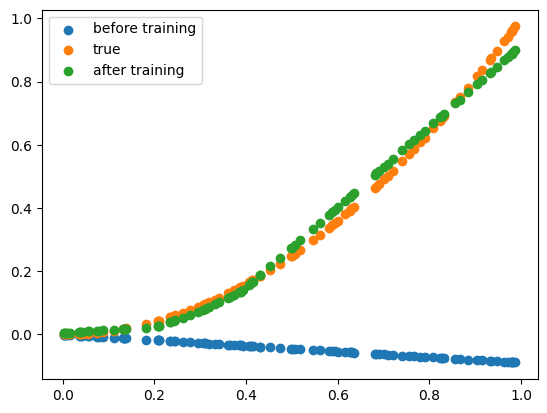

In [6]:
tf_net = TfNet(net)

# lets define a simple training loop to
# to train a network to fit a parabola
x = tf.random.uniform((100, 1))
y = x**2

@tf.function(experimental_compile=True, autograph=False)
def train_step(x: tf.Tensor, y: tf.Tensor):
    """Performs one optimizer step on a single mini-batch."""
    with tf.GradientTape() as tape:
        loss = tf.reduce_mean((tf_net(x) - y) ** 2)
        params = tape.watched_variables()

    grads = tape.gradient(loss, params)

    for param, grad in zip(params, grads):
        param.assign_sub(grad * 1e-3)

    return loss


plt.scatter(x, tf_net(x), label = "before training")

start = time.time()

for i in range(20_000):
    loss = train_step(x, y)

print(f"training took {time.time() - start:.2f} seconds")

plt.scatter(x, y, label = "true")
plt.scatter(x, tf_net(x), label = "after training")
plt.legend()

#### Save the model

In [7]:
tf.saved_model.save(tf_net, "tf_net")

INFO:tensorflow:Assets written to: tf_net/assets


#### Load the model

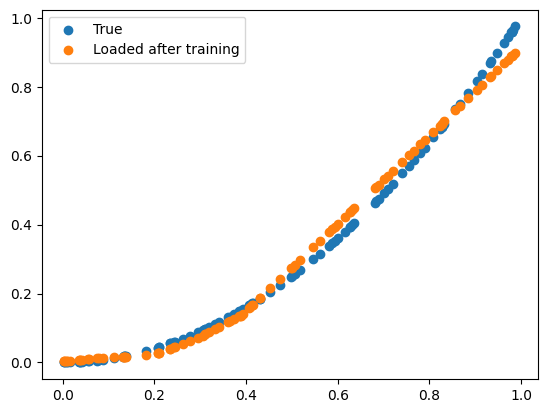

In [8]:
tf_net = TfNet(net)
tf_net.params = tf.saved_model.load("tf_net").params
plt.scatter(x, y, label = "True")
plt.scatter(x, tf_net(x), label = "Loaded after training")
plt.legend()

#### Compare with `jax` training

training took 0.87 seconds


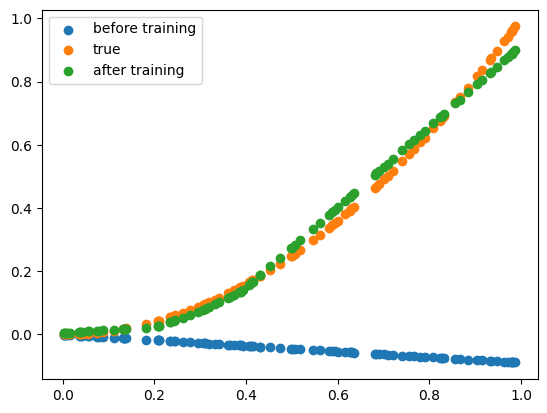

In [9]:
@jax.jit
def train_step(net: Net, x: jax.Array, y: jax.Array):
    def loss_func(net):
        net = sk.tree_unmask(net)
        return jnp.mean((net(x) - y) ** 2)

    grad = jax.grad(loss_func)(net)
    net = jtu.tree_map(lambda x, g: x - g * 1e-3, net, grad)
    return net


net = Net(jax.random.PRNGKey(0))

x_ = x.numpy()
y_ = y.numpy()
plt.scatter(x_, net(x_), label="before training")

# pass non-jaxtype through jax transformations by masking
net = sk.tree_mask(net)

start = time.time()

for i in range(20_000):
    net = train_step(net, x_, y_)
net = sk.tree_unmask(net)


print(f"training took {time.time() - start:.2f} seconds")

plt.scatter(x_, y_, label="true")
plt.scatter(x_, net(x_), label="after training")
plt.legend()